In [120]:
import json, glob, re, os, sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import convert
import confusion_matrix as CM
import visualization as vis

In [121]:
gtPath = "/home/jovyan/nas-dataset/recycling"
pdPath = "/home/jovyan/data-vol-1/detreg_latest/_exps/downstream"

class Result: # result of yolo gt and yolo-liked pd 
    def __init__(self, imFolder, gtFolder, pdFolder, classL=None, classN=None, defaultAspect=(720,1280)):
        self.imPathL = sorted(glob.glob(f"{gtPath}/{imFolder}/*.jpg"))
        self.gtPathL = sorted([ p for p in glob.glob(f"{gtPath}/{gtFolder}/*.txt") if "classes.txt" not in p]) # groundtruth (cid,cx,cy,w,h)
        self.pdPathL = sorted(glob.glob(f"{pdPath}/{pdFolder}/*.txt"))                                         # detections  (cid,cx,cy,w,h,conf)
        assert len(self.imPathL)==len(self.gtPathL)==len(self.pdPathL), (len(self.imPathL),len(self.gtPathL),len(self.pdPathL))
        self.classL  = classL if classL else open(f"{gtFolder}/*.txt","r").readlines()
        self.classN  = classN if classN else [1]*len(classL)
        self.savePath= os.path.dirname(f"{pdPath}/{pdFolder}")
        #
        self.labels, self.detections = self.getLabelDetection(defaultAspect)
        self.PR      = self.getPR()
        self.apL, self.mAP, self.wmAP= self.getAPs()
    
    def getLabelDetection(self, defaultAspect):
        labels, detects = [], []
        for imPath,gtPath,pdPath in zip(self.imPathL, self.gtPathL, self.pdPathL):
            assert os.path.basename(gtPath).replace('.jpg','.txt')==os.path.basename(gtPath)==os.path.basename(pdPath)
            height, width = defaultAspect if defaultAspect else cv2.imread(imPath).shape[:2]
            label, detect = [], []
            for line in open(gtPath,"r").readlines():
                cid, cx, cy, w, h      = line.replace('\n','').split(' ')
                xmin, ymin, xmax, ymax = convert.boxAny2Voc("yolo", cx, cy, w, h, width, height)
                label.append( [int(cid),int(xmin),int(ymin),int(xmax),int(ymax)] ) # cid,xmin,ymin,xmax,ymax
            labels.append( np.array(label) )
            for line in open(pdPath,"r").readlines():
                cid, cx, cy, w, h, cf  = line.replace('\n','').split(' ')
                xmin, ymin, xmax, ymax = convert.boxAny2Voc("yolo", cx, cy, w, h, width, height)
                detect.append( [int(xmin),int(ymin),int(xmax),int(ymax),float(cf),int(cid)] ) # xmin,ymin,xmax,ymax,conf,cid
            detects.append( np.array(detect) )
        return labels, detects
    
    def getPR(self):
        prPath, n = f"{self.savePath}/pr.npy", len(self.classL)
        # Get raw PR
        if glob.glob(prPath):
            print("load pr.npy from cache")
            PR = np.load(prPath, allow_pickle=True)
        else:
            PR = [ {"precision":[0.]*101, "recall":[0.]*101} for i in range(n) ]
            for i in range(101):
                print(f"\rthreshold={round(i*0.01,2)}{'0' if i%10==0 else ''}", end="")
                M = np.zeros( (n+1,n+1) ) # col:gt, row:pd
                for j,(labels,detections) in enumerate(zip(self.labels,self.detections)):
                    cm = CM.ConfusionMatrix(n, CONF_THRESHOLD=i*0.01, IOU_THRESHOLD=0.5)
                    cm.process_batch(detections,labels)
                    M += cm.return_matrix()
                rowSum, colSum = M.sum(axis=1), M.sum(axis=0)
                for j in range(n):
                    PR[j]["precision"][i] = M[j][j]/rowSum[j] if rowSum[j] else 0
                    PR[j]["recall"][i]    = M[j][j]/colSum[j] if colSum[j] else 0
            np.save(prPath, PR)
            print()
        # Refine PR: sorted by recall, and enhance precision by next element reversely
        for i in range(n):
            R, P = PR[i]["recall"][:], PR[i]["precision"][:]
            Z = sorted(zip(R,P))
            R, P = zip(*Z)
            R, P = list(R), list(P)
            for j in range(1,101):
                P[-1-j] = max(P[-1-j], P[-j])
            PR[i]["refineRecall"], PR[i]["refinePrecision"] = R, P
        return PR

    def getAPs(self): # calculate area under PR curve
        apL, mAP, wmAP, n = [], 0, 0, len(self.classL)
        for i in range(n):
            ap = 0
            for j in range(100):
                ap += self.PR[i]["refinePrecision"][j]*(self.PR[i]["refineRecall"][j+1]-self.PR[i]["refineRecall"][j])
            apL.append( round(ap,3) )
            mAP  += ap/n
            wmAP += ap*self.classN[i]/sum(self.classN)
        mAP  = round(float(mAP),3)
        wmAP = round(float(wmAP),3)
        print(f"apL={apL}, mAP={mAP}, wmAP={wmAP}")
        return apL, mAP, wmAP
    
    def plotAP(self, showMAP=False, showAPS=False):
        R = list(range(len(self.classL)))
        plt.figure()
        ax = plt.subplot(1,1,1)
        ax.set_title(f"{'mAP='+str(self.mAP)+', ' if showAPS else ''}wmAP={self.wmAP}", fontsize=16)
        ax.bar(self.classL, self.apL)
        if showAPS:
            for i in range(len(self.classL)):
                ax.text(R[i], self.apL[i], self.apL[i], ha="center", va="bottom", fontsize=16)
        plt.savefig(f"{self.savePath}/ap.jpg")
        plt.show()
   
    def plotPR(self):
        n = len(self.classL)
        plt.figure(figsize=(6*n,8))
        for i in range(n):
            plt.subplot(2,n,1+i)
            plt.scatter( self.PR[i]["refineRecall"], self.PR[i]["refinePrecision"] )
            plt.plot( self.PR[i]["refineRecall"], self.PR[i]["refinePrecision"] )
            plt.xlim(-0.05,1.05)
            plt.ylim(-0.05,1.05)
            plt.grid('on')
            plt.title(f"class-{i}", fontsize=16)
            plt.xlabel("recall", fontsize=16)
            plt.ylabel("precision", fontsize=16)

            plt.subplot(2,n,1+i+n)
            plt.plot( self.PR[i]["precision"])
            plt.plot( self.PR[i]["recall"])
            plt.plot( [(self.PR[i]["precision"][j]+self.PR[i]["recall"][j])/2 for j in range(101)] )
            plt.xlim(-5,105)
            plt.ylim(-0.05,1.05)
            plt.grid('on')
            #plt.title(f"class-{i}", fontsize=16)
            plt.xlabel("threshold", fontsize=16)
            plt.legend(labels=["precision","recall","fvalue"], fontsize=12)
        plt.savefig(f"{self.savePath}/pr.jpg")
        plt.show()
        
        # overall PR
        plt.figure(figsize=(6*2,4))
        allPrecision, allRecall, allF = [0]*101, [0]*101, [0]*101
        for i in range(101):
            allPrecision[i] = sum( self.PR[j]['refinePrecision'][i] for j in range(n) )/n
            allRecall[i]    = sum( self.PR[j]['refineRecall'][i]    for j in range(n) )/n
            allF[i]         = allPrecision[i]*allRecall[i] / (allPrecision[i]+allRecall[i]) if allPrecision[i]+allRecall[i] else 0
        plt.subplot(1,2,1)
        plt.title('overall', fontsize=16)
        plt.plot(allPrecision)
        plt.plot(allRecall)
        plt.plot(allF)
        plt.grid('on')
        plt.legend(labels=['precision','recall','fvalue'], fontsize=12)
        plt.subplot(1,2,2)
        plt.title('overall', fontsize=16)
        plt.plot(allRecall, allPrecision)
        plt.grid('on')
        plt.show()
    
    def _getBestThreshold(self):
        n = len(self.classL)
        wScore = [0]*101
        for i in range(101):
            for j in range(n):
                p, r = self.PR[j]["precision"][i], self.PR[j]["recall"][i]
                if self.strategy=="fvalue":
                    score = 2*p*r/(p+r) if p+r else 0
                elif self.strategy=="precision":
                    score = p if r>=0.5 else 0
                elif self.strategy=="recall":
                    score = r if p>=0.5 else 0
                else:
                    raise
                wScore[i] += score*self.classN[j]/sum(self.classN)
        bestScore, self.bestThreshold = max(zip(wScore,[round(0.01*i,2) for i in range(101)]))
        print(f"bestScore={round(bestScore,2)}, best_threshold={self.bestThreshold}")
    
    def plotConfusion(self, strategy="fvalue"):
        self.strategy = strategy
        self._getBestThreshold()
        n = len(self.classL)
        M = np.zeros( (n+1,n+1) ) # col:gt, row:pd
        self.accumFileL = [ [[] for j in range(n+1)] for i in range(n+1) ] # (n+1,n+1) each grid is path list
        #for j,(gtPath,labels,detections) in enumerate(zip(self.gtPathL,self.labels,self.detections)):
        for j,(imgPath,labels,detections) in enumerate(zip(self.imPathL,self.labels,self.detections)):
            cm = CM.ConfusionMatrix(n, CONF_THRESHOLD=self.bestThreshold, IOU_THRESHOLD=0.5, gtFile=imgPath.split("/")[-1], accumFileL=self.accumFileL)
            cm.process_batch(detections,labels)
            M += cm.return_matrix()
            self.accumFileL = cm.getAccumFileL()
        #
        axis0sum = M.sum(axis=0)
        N = M.copy()
        for i in range(len(N)):
            if axis0sum[i] != 0:
                N[:,i] /= axis0sum[i]
        axis1sum = M.sum(axis=1)
        P = M.copy()
        for i in range(len(P)):
            if axis1sum[i] != 0:
                P[i,:] /= axis1sum[i]
        #
        plt.figure(figsize=(15,5))
        # fig1 - number
        fig = plt.subplot(1,3,1)
        plt.title(f"Confusion Matrix - Number (conf={self.bestThreshold})", fontsize=12)
        plt.xlabel("GT", fontsize=12)
        plt.ylabel("PD", fontsize=12)
        fig.set_xticks(np.arange(n+1)) # values
        fig.set_xticklabels(self.classL+['BG']) # labels
        fig.set_yticks(np.arange(n+1)) # values
        fig.set_yticklabels(self.classL+['BG']) # labels
        plt.imshow(P, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
        for i in range(n+1):
            for j in range(n+1):
                plt.text(j, i, int(M[i][j]), ha="center", va="center", color="black" if P[i][j]<0.9 else "white", fontsize=12)
        # fig2 - precision
        fig = plt.subplot(1,3,2)
        plt.title(f"Confusion Matrix - Row norm (Precision)", fontsize=12)
        plt.xlabel("GT", fontsize=12)
        plt.ylabel("PD", fontsize=12)
        fig.set_xticks(np.arange(n+1)) # values
        fig.set_xticklabels(self.classL+['BG']) # labels
        fig.set_yticks(np.arange(n+1)) # values
        fig.set_yticklabels(self.classL+['BG']) # labels
        plt.imshow(P, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
        for i in range(n+1):
            for j in range(n+1):
                plt.text(j, i, round(P[i][j],2), ha="center", va="center", color="black" if P[i][j]<0.9 else "white", fontsize=12)
        # fig3 - recall
        fig = plt.subplot(1,3,3)
        plt.title(f"Confusion Matrix - Col norm (Recall)", fontsize=12)
        plt.xlabel("GT", fontsize=12)
        plt.ylabel("PD", fontsize=12)
        fig.set_xticks(np.arange(n+1)) # values
        fig.set_xticklabels(self.classL+['BG']) # labels
        fig.set_yticks(np.arange(n+1)) # values
        fig.set_yticklabels(self.classL+['BG']) # labels
        plt.imshow(N, cmap=mpl.cm.Blues, interpolation='nearest', vmin=0, vmax=1)
        for i in range(n+1):
            for j in range(n+1):
                plt.text(j, i, round(N[i][j],2), ha="center", va="center", color="black" if N[i][j]<0.9 else "white", fontsize=12)
        #plt.colorbar(mpl.cm.ScalarMappable(cmap=mpl.cm.Blues))
        plt.savefig(f"{self.savePath}/confusion.jpg")
        plt.show()
        json.dump(self.accumFileL, open(f"{self.savePath}/confusionFiles.json","w"))
        
    def getBlockImgs(self, row, col, threshold='best'): # PD, GT
        classL = self.classL + ['BG']
        folder = f"{self.savePath}/GT_{classL[col]}_PD_{classL[row]}"
        os.makedirs(folder, exist_ok=True)
        threshold = self.bestThreshold if threshold=='best' else threshold
        imgNameL  = [ os.path.basename(imgPath) for imgPath in self.imPathL ]
        for imgName in self.accumFileL[row][col]:
            idx = imgNameL.index(imgName)
            det = self.detections[idx]
            if not len(det):
                continue
            det = det[det[:,4]>threshold]
            vis.show( self.imPathL[idx], self.gtPathL[idx], 'voc', det[:,:4], det[:,5].astype(int), det[:,4], self.classL, folder, (1.7,1.7) )
            break
        print(f"len(glob.glob(folder+'/*.jpg'))={len(glob.glob(folder+'/*.jpg'))}")

load pr.npy from cache
apL=[0, 0, 0.995], mAP=0.332, wmAP=0.332


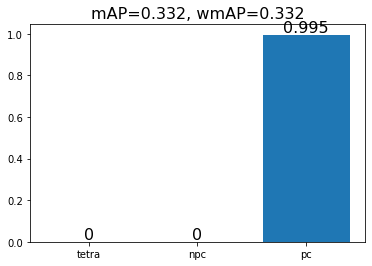

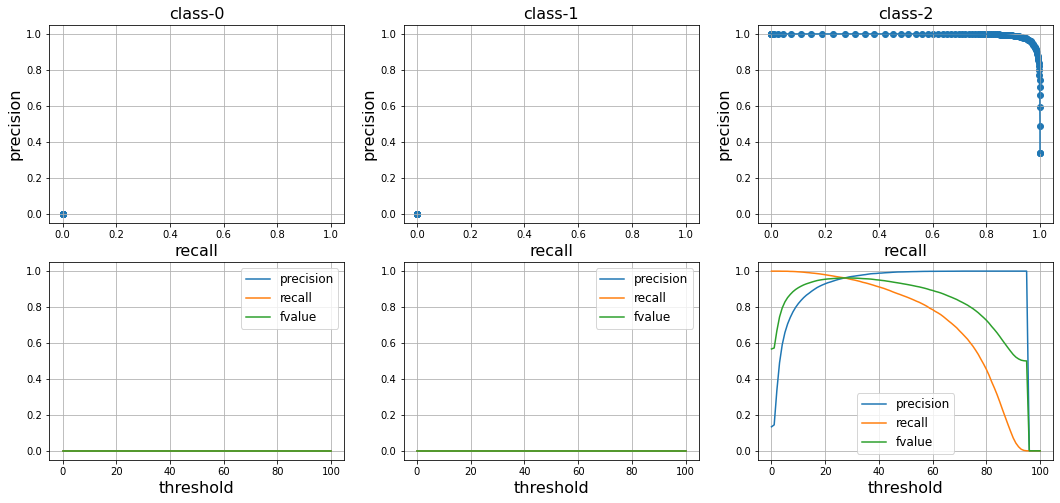

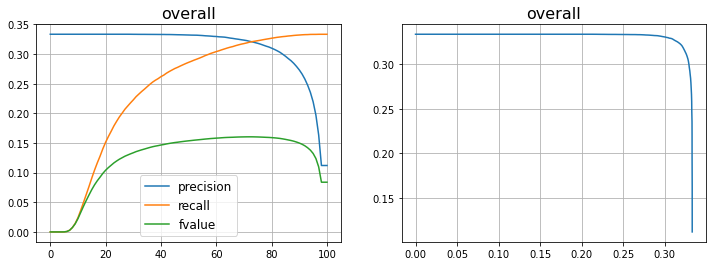

bestScore=0.33, best_threshold=0.78


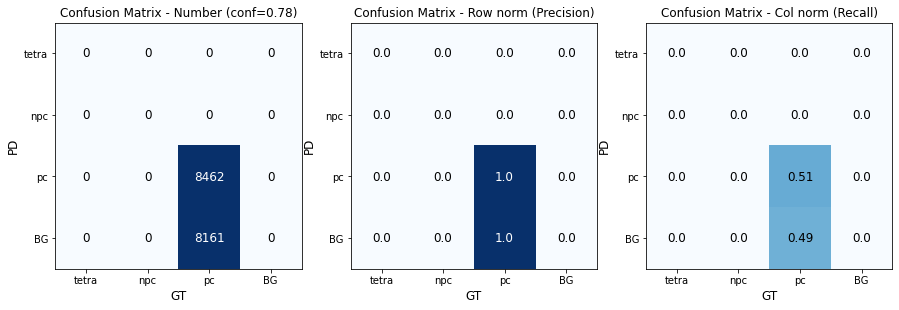

bestScore=0.32, best_threshold=0.28


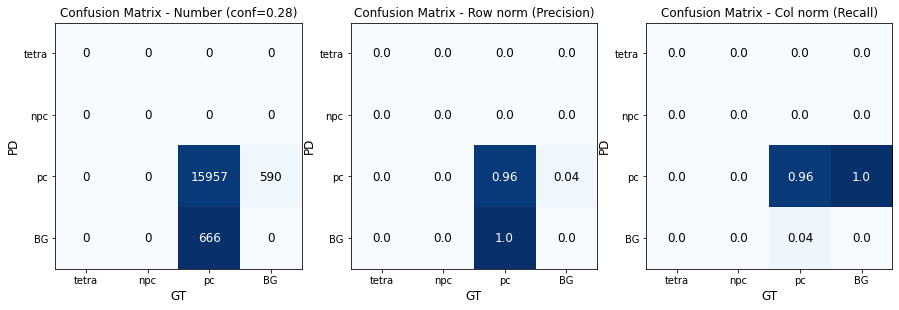

len(glob.glob(folder+'/*.jpg'))=1
len(glob.glob(folder+'/*.jpg'))=1


In [123]:
obj = Result("backboneData/2022-06-14", "backboneData/2022-06-14_label_papercontainer_v5", "example/output", ['tetra','npc','pc'])
obj.plotAP(showMAP=False, showAPS=True)
obj.plotPR()
obj.plotConfusion(strategy="precision")
#obj.getBlockImgs(0,1)
obj.plotConfusion(strategy="fvalue")
obj.getBlockImgs(2,2)
obj.getBlockImgs(2,3)